In [1]:
import pandas as pd
import numpy as np

In [2]:


# Load the .npz file
data = np.load("../archive/myo_ds_30l_10ol.npz")

# List all arrays inside
print(data.files)

# Access an array by name
array1 = data["y"]  # Replace "array_name" with an actual key

# Print the array
print(array1)

['X', 'y']
[0 0 0 ... 0 0 0]


### Labeling as fist and release for every 2 seconds

In [3]:
# df = pd.read_csv("../lab_1/emg_filename.csv")
# print(df.columns)
# df["newTimeStamp"]=df[' Timestamp'].str.replace(r' (\d{6})$', r'.\1', regex=True)


# # Convert to datetime
# df['newTimeStamp'] = pd.to_datetime(df['newTimeStamp'])

# # Get elapsed time in seconds from the first timestamp
# df['elapsed_seconds'] = (df['newTimeStamp'] - df['newTimeStamp'].min()).dt.total_seconds()

# # Assign labels alternating every 2 seconds
# df['label'] = df['elapsed_seconds'].floordiv(2) % 2
# df['label'] = df['label'].map({0: 'release', 1: 'fist'})

# # Display result
# # df.to_csv("output.csv")
# df.columns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
df=pd.read_csv("output.csv")
print(df.columns)
df1=df.drop(['newTimeStamp', 'elapsed_seconds' ,'Unnamed: 0'],axis="columns")
X = df1.drop("label", axis="columns")
y = df1.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y  )



Index(['Unnamed: 0', 'Device ID', ' Warm?', ' Sync', ' Arm', ' Timestamp',
       ' Orientation_W', ' Orientation_X', ' Orientation_Y', ' Orientation_Z',
       ' Acc_X', ' Acc_Y', ' Acc_Z', ' Gyro_X', ' Gyro_Y', ' Gyro_Z', ' Pose',
       ' EMG_1', ' EMG_2', ' EMG_3', ' EMG_4', ' EMG_5', ' EMG_6', ' EMG_7',
       ' EMG_8', 'Locked', ' RSSI', ' Roll', ' Pitch', ' Yaw ', 'newTimeStamp',
       'elapsed_seconds', 'label'],
      dtype='object')


In [6]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        return self  # No fitting necessary for this transformer
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    

class ChunkedMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, chunk_size=200):
        self.chunk_size = chunk_size

    def fit(self, X, y=None):
        return self  # No fitting required

    def transform(self, X):
        X_transformed = X.copy()  # Avoid modifying original data
        num_rows = X.shape[0]
        
        for start in range(0, num_rows, self.chunk_size):
            end = min(start + self.chunk_size, num_rows)
            
            # Compute median per feature
            median_values = X.iloc[start:end].median(axis=0)

            # Convert each column individually to its original dtype
            for col in X.columns:
                median_values[col] = median_values[col].astype(X[col].dtype)
            
            # Assign median values to the chunk
            X_transformed.iloc[start:end] = median_values.values
        
        return X_transformed

# class SlidingMedianTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, window_size=3):
#         self.window_size = window_size  # Number of elements in the window

#     def fit(self, X, y=None):
#         return self  # No fitting required

#     def transform(self, X):
#         if not isinstance(X, pd.DataFrame):
#             X = pd.DataFrame(X)  # Convert to DataFrame if not already
        
#         X_transformed = X.copy()  # Make a copy to store results
        
#         for col in X.columns:  # Apply sliding median for each column separately
#             values = X[col].values
#             if len(values) < self.window_size:
#                 raise ValueError(f"Window size {self.window_size} is larger than the number of rows {len(values)}")
            
#             medians = [np.median(values[i:i + self.window_size]) for i in range(len(values) - self.window_size + 1)]
            
#             # Padding with NaNs to maintain shape
#             X_transformed[col] = np.pad(medians, (0, self.window_size - 1), mode='constant', constant_values=np.nan)
        
#         return X_transformed.dropna()


# List of columns to drop (for example, 'sepal length (cm)' and 'sepal width (cm)')
columns_to_remove = ['Device ID', ' Warm?', ' Sync', ' Arm', ' Timestamp', 'Locked', ' Pose']

# For real world
#columns_to_remove = ['Device ID', ' Warm?', ' Sync', ' Arm', ' Timestamp', 'Locked', ' Pose']

LogisticRegression_pipeline = Pipeline([
     ('drop_columns', DropColumnsTransformer(columns_to_remove)),
    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', LogisticRegression())  # Logistic regression model
])

general_pipeline=Pipeline([
     ('drop_columns', DropColumnsTransformer(columns_to_remove)),
    ('scaler', StandardScaler()) # Logistic regression model
])


LogisticRegression_pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

# Assuming y_test is the true labels and y_pred is the predicted labels
accuracy = accuracy_score(y_test, LogisticRegression_pipeline.predict(X_test))
from sklearn.metrics import classification_report
print(classification_report(y_test, LogisticRegression_pipeline.predict(X_test)))

              precision    recall  f1-score   support

        fist       0.61      0.57      0.59      2523
     release       0.62      0.66      0.64      2633

    accuracy                           0.62      5156
   macro avg       0.62      0.61      0.61      5156
weighted avg       0.62      0.62      0.61      5156



In [7]:
from sklearn.svm import SVC
svm_pipeline = Pipeline([
     ('drop_columns', DropColumnsTransformer(columns_to_remove)),
    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', SVC(kernel='rbf'))  
])


svm_pipeline.fit(X_train,y_train)


# Assuming y_test is the true labels and y_pred is the predicted labels
accuracy = accuracy_score(y_test, svm_pipeline.predict(X_test))
print(classification_report(y_test, svm_pipeline.predict(X_test)))
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

        fist       0.71      0.70      0.70      2523
     release       0.71      0.72      0.72      2633

    accuracy                           0.71      5156
   macro avg       0.71      0.71      0.71      5156
weighted avg       0.71      0.71      0.71      5156

Classification Accuracy: 70.97%


In [8]:
from sklearn.ensemble import RandomForestClassifier
randomforest_pipeline = Pipeline([
     ('drop_columns', DropColumnsTransformer(columns_to_remove)),

    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', RandomForestClassifier(n_estimators=50))
])


randomforest_pipeline.fit(X_train,y_train)


# Assuming y_test is the true labels and y_pred is the predicted labels
accuracy = accuracy_score(y_test, randomforest_pipeline.predict(X_test))
print(classification_report(y_test, randomforest_pipeline.predict(X_test)))
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

        fist       0.99      0.99      0.99      2523
     release       0.99      0.99      0.99      2633

    accuracy                           0.99      5156
   macro avg       0.99      0.99      0.99      5156
weighted avg       0.99      0.99      0.99      5156

Classification Accuracy: 99.19%


In [9]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(randomforest_pipeline, X_test, y_test, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean() * 100:.2f}%")


Cross-validation scores: [0.96027132 0.96799224 0.97769156 0.9757517  0.95247333]
Mean cross-validation score: 96.68%


In [10]:
print(randomforest_pipeline.predict(X_test)+" "+y_test)

6491     release release
884      release release
6244           fist fist
13229          fist fist
7966           fist fist
              ...       
680            fist fist
2631     release release
14450    release release
11010          fist fist
4726           fist fist
Name: label, Length: 5156, dtype: object


### new Approach

In [11]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [12]:
models = {
        
        'RandomForest': {
            'model': RandomForestClassifier(),
            'params': {
                'randomforestclassifier__n_estimators': [100, 200],
                'randomforestclassifier__max_depth': [20, 30],
                'randomforestclassifier__class_weight': ['balanced']
            }
            },
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'logisticregression__C': [0.1, 1, 10],
                'logisticregression__class_weight': ['balanced']
                }
            }  
        }

best_models = {}
for name, mp in models.items():
        pipeline = make_pipeline(general_pipeline, mp['model'])
        grid = GridSearchCV(pipeline, param_grid=mp['params'], scoring='f1', cv=4, return_train_score=False,n_jobs=-1)
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        print(name)
        print(grid.best_params_)

        
voting_estimators = [(name, model) for name, model in best_models.items()]
clf = VotingClassifier(estimators=voting_estimators, voting='soft')
clf.fit(X_train,y_train)
        

c:\Users\haris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


RandomForest
{'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 100}


c:\Users\haris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


LogisticRegression
{'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced'}


VotingClassifier(estimators=[('RandomForest',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('drop_columns',
                                                                DropColumnsTransformer(columns_to_drop=['Device '
                                                                                                        'ID',
                                                                                                        ' '
                                                                                                        'Warm?',
                                                                                                        ' '
                                                                                                        'Sync',
                                                                                                        ' '
                                                                                                        'Arm',
                                                                                                        ' '
                                                                                                        'Timestamp',
                                                                                                        'Locked',
                                                                                                        ' '
                                                                                                        'Pose'])),
                                                               ('scaler',
                                                                StandardScaler())])),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=20))])),
                             ('LogisticRegression',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('drop_columns',
                                                                DropColumnsTransformer(columns_to_drop=['Device '
                                                                                                        'ID',
                                                                                                        ' '
                                                                                                        'Warm?',
                                                                                                        ' '
                                                                                                        'Sync',
                                                                                                        ' '
                                                                                                        'Arm',
                                                                                                        ' '
                                                                                                        'Timestamp',
                                                                                                        'Locked',
                                                                                                        ' '
                                                                                                        'Pose'])),
                                                               ('scaler',
                                                                StandardScaler())])),
                                              ('logisticregression',
                                               LogisticRegression(C=0.1,
             

In [13]:
accuracy = accuracy_score(y_test, clf.predict(X_test))

print(f"Classification Accuracy: {accuracy * 100:.2f}%")

Classification Accuracy: 98.93%


### File Reader

In [14]:
pd.set_option('display.max_rows', None)  # None will display all rows
pd.set_option('display.max_columns', None)  # None will display all columns
pd.set_option('display.width', None)  # Adjust width to fit all columns
pd.set_option('display.max_colwidth', None) 

In [16]:
# The CSV file to monitor
csv_file = '../Lab_1/emg_filename.csv'

# Function to read the CSV file continuously and process new rows
def monitor_and_process_file():
    # Keep track of the number of lines that have already been processed
    last_line_count = 0

    while True:
        # Check the current line count in the file
        current_line_count = sum(1 for line in open(csv_file, 'r'))
        
        # If new rows have been written, process them
        if current_line_count > last_line_count:
            # Read the new rows
            new_data = pd.read_csv(csv_file, skiprows=range(1, last_line_count + 1))
            
            # Process the new data (you can pass this data to your model)
            print("Processing new rows...")
            print(new_data.columns)

            # Update the last line count
            last_line_count = current_line_count
            print(randomforest_pipeline.predict(new_data))
            


# Run the monitoring function
monitor_and_process_file()

Processing new rows...
Index(['Device ID', ' Warm?', ' Sync', ' Arm', ' Timestamp', ' Orientation_W',
       ' Orientation_X', ' Orientation_Y', ' Orientation_Z', ' Acc_X',
       ' Acc_Y', ' Acc_Z', ' Gyro_X', ' Gyro_Y', ' Gyro_Z', ' Pose', ' EMG_1',
       ' EMG_2', ' EMG_3', ' EMG_4', ' EMG_5', ' EMG_6', ' EMG_7', ' EMG_8',
       'Locked', ' RSSI', ' Roll', ' Pitch', ' Yaw '],
      dtype='object')
['release' 'release' 'release' ... 'release' 'release' 'release']


KeyboardInterrupt: 

In [17]:
# Set chunk size for reading the file incrementally
chunk_size = 400  # for example, read 200 rows at a time

# Initialize a counter to track the number of rows read
rows_read = 0

# Create a list to hold all the chunks (optional, for full read, but can be avoided for large files)
df_list = []

# Open the CSV and read in chunks
while True:
    for chunk in pd.read_csv('../Lab_1/emg_filename.csv', chunksize=chunk_size):
        # Process the chunk (here you can modify or analyze the chunk as needed)
        rows_read += len(chunk)
        
        df_list.append(chunk)  # Optional, if you want to collect all chunks
        #print(chunk.columns)
        # For demonstration, printing current chunk size and total rows read
        # print(f"Rows read: {rows_read}")
        # print(chunk.head())  # To show a preview of the current chunk
        print(randomforest_pipeline.predict(chunk))
    

['release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'release' 'release' 'release' 'release' 'release' 'release' 'release'
 'rele

KeyboardInterrupt: 

array([[<Axes: title={'center': ' Orientation_W'}>,
        <Axes: title={'center': ' Orientation_X'}>,
        <Axes: title={'center': ' Orientation_Y'}>,
        <Axes: title={'center': ' Orientation_Z'}>,
        <Axes: title={'center': ' Acc_X'}>],
       [<Axes: title={'center': ' Acc_Y'}>,
        <Axes: title={'center': ' Acc_Z'}>,
        <Axes: title={'center': ' Gyro_X'}>,
        <Axes: title={'center': ' Gyro_Y'}>,
        <Axes: title={'center': ' Gyro_Z'}>],
       [<Axes: title={'center': ' EMG_1'}>,
        <Axes: title={'center': ' EMG_2'}>,
        <Axes: title={'center': ' EMG_3'}>,
        <Axes: title={'center': ' EMG_4'}>,
        <Axes: title={'center': ' EMG_5'}>],
       [<Axes: title={'center': ' EMG_6'}>,
        <Axes: title={'center': ' EMG_7'}>,
        <Axes: title={'center': ' EMG_8'}>,
        <Axes: title={'center': ' RSSI'}>,
        <Axes: title={'center': ' Roll'}>],
       [<Axes: title={'center': ' Pitch'}>,
        <Axes: title={'center': ' Yaw '

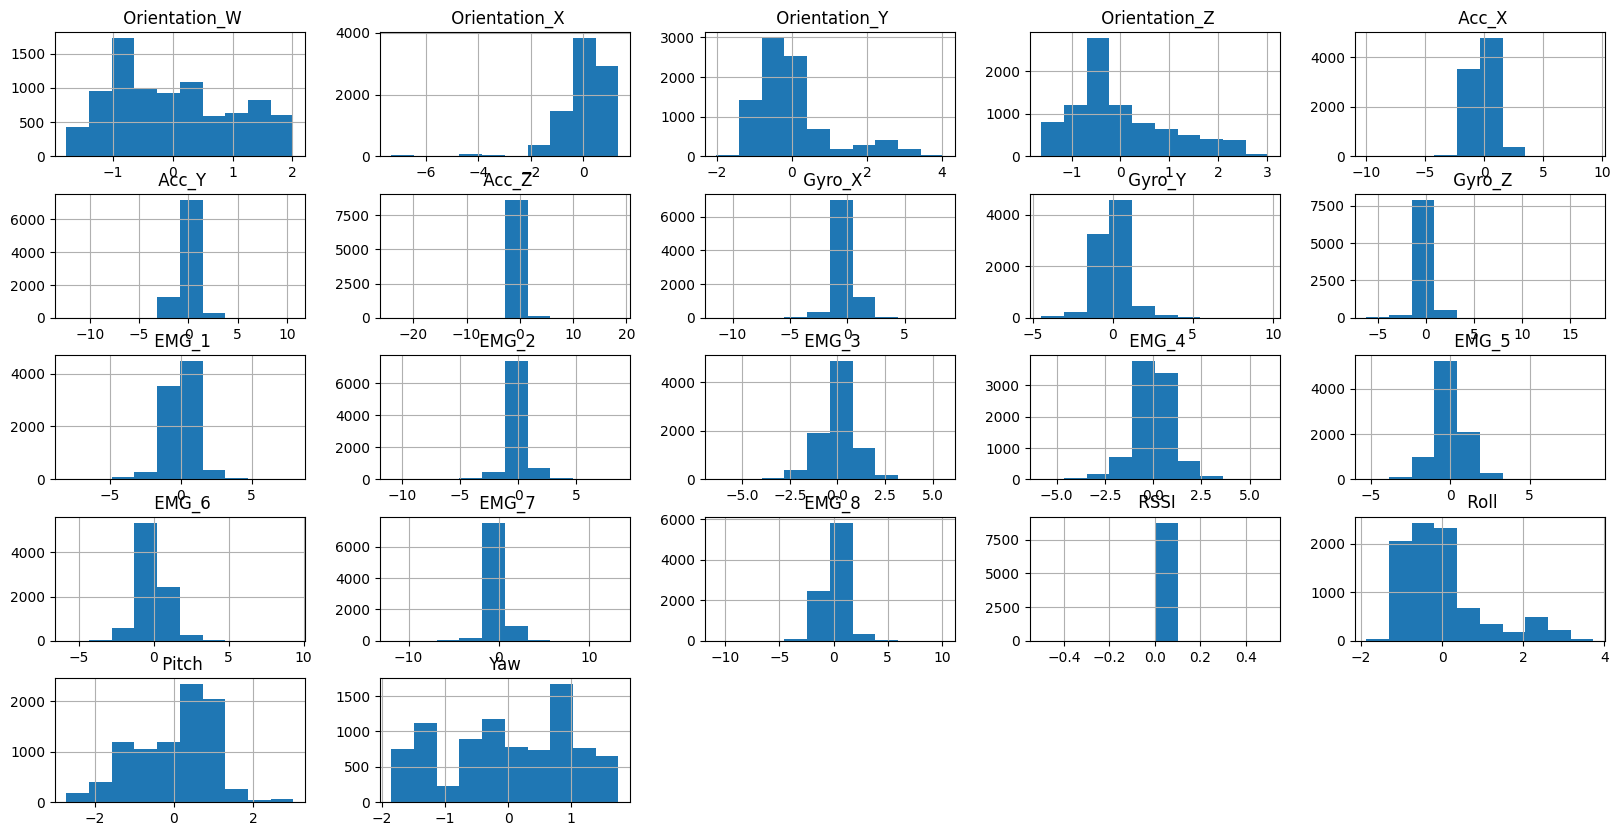

In [ ]:
coormatrixDF = df1.drop(['Device ID', ' Warm?', ' Sync', ' Arm', ' Timestamp', 'Locked', ' Pose', 'label'],axis="columns")
coormatrixDF_fist = df1[df1["label"]=="release"].drop(['Device ID', ' Warm?', ' Sync', ' Arm', ' Timestamp', 'Locked', ' Pose', 'label'],axis="columns")
# coormatrixDF.count()
#coormatrixDF_fist.corr()

sd=StandardScaler()
coormatrixDF_fist_normalized = sd.fit_transform(coormatrixDF_fist)
coormatrixDF_fist_normalized=pd.DataFrame(coormatrixDF_fist_normalized,columns=coormatrixDF_fist.columns)
coormatrixDF_fist_normalized.hist(figsize=(20,10))



array([[<Axes: title={'center': ' Orientation_W'}>,
        <Axes: title={'center': ' Orientation_X'}>,
        <Axes: title={'center': ' Orientation_Y'}>,
        <Axes: title={'center': ' Orientation_Z'}>,
        <Axes: title={'center': ' Acc_X'}>],
       [<Axes: title={'center': ' Acc_Y'}>,
        <Axes: title={'center': ' Acc_Z'}>,
        <Axes: title={'center': ' Gyro_X'}>,
        <Axes: title={'center': ' Gyro_Y'}>,
        <Axes: title={'center': ' Gyro_Z'}>],
       [<Axes: title={'center': ' EMG_1'}>,
        <Axes: title={'center': ' EMG_2'}>,
        <Axes: title={'center': ' EMG_3'}>,
        <Axes: title={'center': ' EMG_4'}>,
        <Axes: title={'center': ' EMG_5'}>],
       [<Axes: title={'center': ' EMG_6'}>,
        <Axes: title={'center': ' EMG_7'}>,
        <Axes: title={'center': ' EMG_8'}>,
        <Axes: title={'center': ' RSSI'}>,
        <Axes: title={'center': ' Roll'}>],
       [<Axes: title={'center': ' Pitch'}>,
        <Axes: title={'center': ' Yaw '

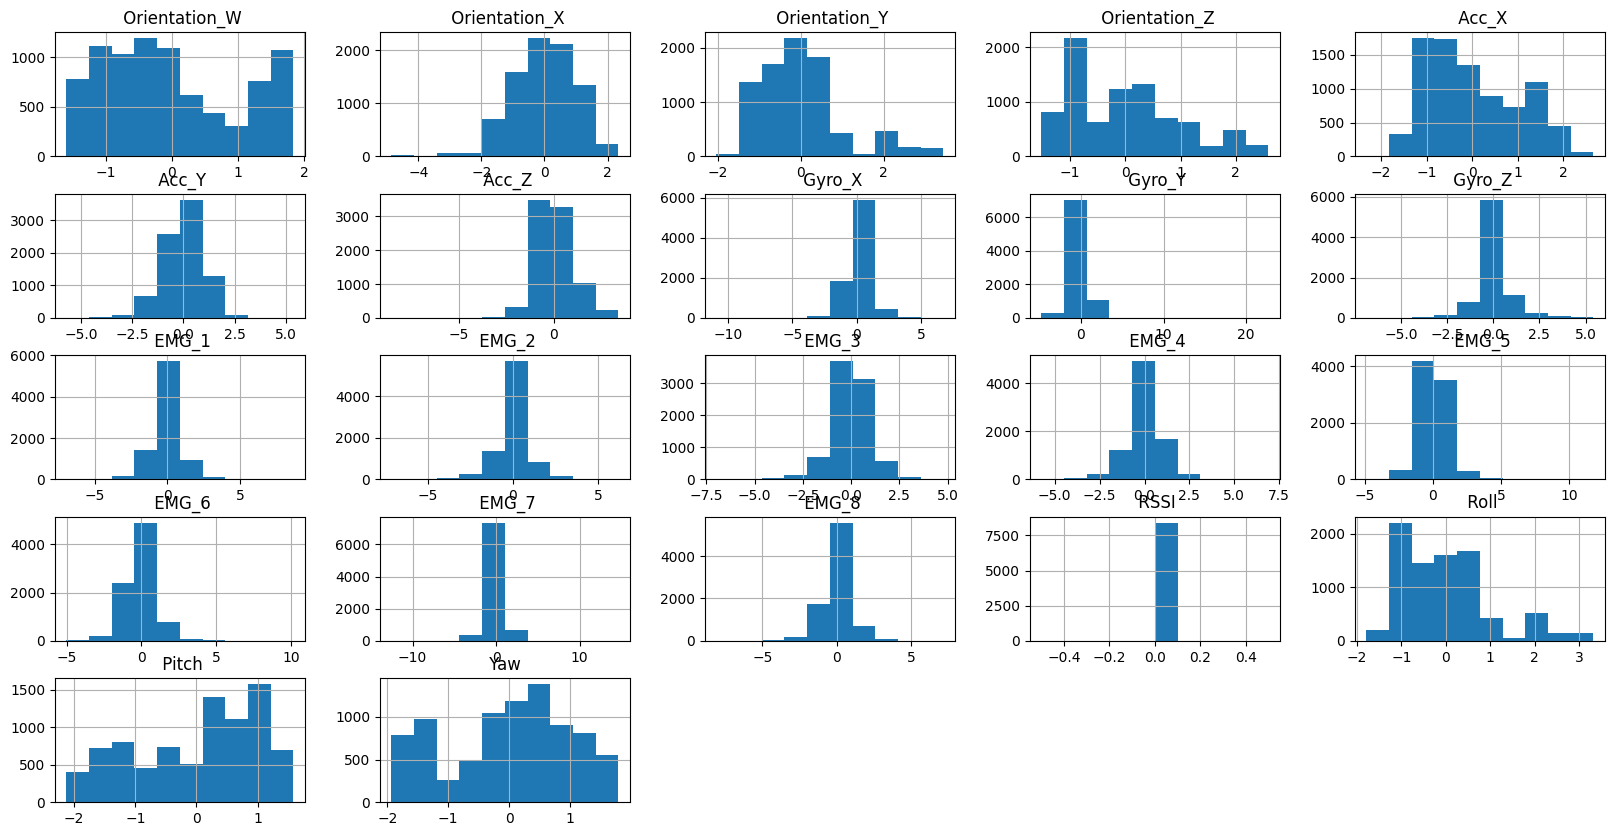

In [ ]:
coormatrixDF = df1.drop(['Device ID', ' Warm?', ' Sync', ' Arm', ' Timestamp', 'Locked', ' Pose', 'label'],axis="columns")
coormatrixDF_fist = df1[df1["label"]=="fist"].drop(['Device ID', ' Warm?', ' Sync', ' Arm', ' Timestamp', 'Locked', ' Pose', 'label'],axis="columns")
# coormatrixDF.count()
#coormatrixDF_fist.corr()

sd=StandardScaler()
coormatrixDF_fist_normalized = sd.fit_transform(coormatrixDF_fist)
coormatrixDF_fist_normalized=pd.DataFrame(coormatrixDF_fist_normalized,columns=coormatrixDF_fist.columns)
coormatrixDF_fist_normalized.hist(figsize=(20,10))